In [1]:
from GraphModels.model import *
from GraphModels.solvers import *
from GraphModels.metrics import *
import networkx as nx
import matplotlib.pyplot as plt
import random
from experiments import *
import pickle

from scipy.optimize import curve_fit
import scipy as sc
from scipy.stats import multivariate_normal, multivariate_t

from sklearn.covariance import GraphicalLassoCV

import os
import warnings

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
def f(x, a, b, c):
    return a * np.power(x, b) + c

params = curve_fit(f, np.arange(0.1, 1, 0.1), [0.94, 0.87, 0.85, 0.77, 0.74, 0.68, 0.64, 0.55, 0.4])[0]

# Запуск экспериментов для MHT

In [4]:
N = 20
n = 40
S_exp = 10
S_obs = 2

solver = MHTSolver(0.05, pcorr_pvalues, pcorrcoef)

data = [familywise_MHT_experiments(CholPCorrModel, solver, N, f(dens, *params), n, S_exp, S_obs,
                                   [TN, FN, FP, TP], verbose=True, dist=multivariate_t, df=3) for dens in np.arange(0.1, 1, 0.1)]
data = np.stack(data)

data.shape

Family-wise MHT experiment with 0.913 completed in time: 2.266s
Family-wise MHT experiment with 0.887 completed in time: 2.114s
Family-wise MHT experiment with 0.85 completed in time: 1.586s
Family-wise MHT experiment with 0.802 completed in time: 1.768s
Family-wise MHT experiment with 0.745 completed in time: 1.79s
Family-wise MHT experiment with 0.68 completed in time: 1.54s
Family-wise MHT experiment with 0.606 completed in time: 1.433s
Family-wise MHT experiment with 0.523 completed in time: 1.457s
Family-wise MHT experiment with 0.434 completed in time: 1.483s


(9, 10, 2, 4, 5)

# Запуск экспериментов для GL

In [5]:
N = 20
n = 40
S_exp = 2
S_obs = 2

solver = GraphicalLassoCV(tol=1e-6, assume_centered=True, n_jobs=-1)

data = [familywise_GL_experiments(CholPCorrModel, solver, N, f(dens, *params), n, S_exp, S_obs,
                                  verbose=True, dist=multivariate_t, df=3)[0] for dens in np.arange(0.1, 1, 0.1)]
data = np.stack(data)

data.shape

Family-wise GL experiment with 0.913 completed in time: 4.925s
Family-wise GL experiment with 0.887 completed in time: 6.132s
Family-wise GL experiment with 0.85 completed in time: 6.876s
Family-wise GL experiment with 0.802 completed in time: 7.469s
Family-wise GL experiment with 0.745 completed in time: 5.223s
Family-wise GL experiment with 0.68 completed in time: 5.481s
Family-wise GL experiment with 0.606 completed in time: 4.975s
Family-wise GL experiment with 0.523 completed in time: 7.339s
Family-wise GL experiment with 0.434 completed in time: 6.054s


(9, 2, 2, 4, 1)

In [ ]:
with open('experiment_data.bin', 'wb') as f:
    pickle.dump(data, f)

In [11]:
with open('etc/200experimentPcorrGL40.bin', 'rb') as f:
    data1 = pickle.load(f)

with open('etc/800experimentPcorrGL40.bin', 'rb') as f:
    data2 = pickle.load(f)
    
data_combined = np.concatenate([data1, data2], axis=1)

with open('etc/experimentPcorrGL40.bin', 'wb') as f:
    pickle.dump(data_combined, f)

# Анализ и графики для MHT

In [9]:
fname = 'experimentTau300T'

with open(f'etc/{fname}.bin', 'rb') as f:
    data = pickle.load(f)

In [10]:
data.shape

(9, 1000, 200, 4, 5)

In [11]:
def prepare_data(data):
    exp_combined = data.reshape((9, -1, 4, 5))
    fdr_c, fomr_c, tnr_c, tpr_c = [], [], [], []
    bacc_c, f1_c, mcc_c = [], [], []

    for i in range(9):
        tns = exp_combined[i, :, 0, :]
        fns = exp_combined[i, :, 1, :]
        fps = exp_combined[i, :, 2, :]
        tps = exp_combined[i, :, 3, :]

        tnr = tns / (fps + tns)
        tpr = tps / (fns + tps)
        fdr = fps / (fps + tps)
        fomr = fns / (fns + tns)

        fdr_f = np.nan_to_num(fdr)
        fomr_f = np.nan_to_num(fomr)
        tnr_f = np.nan_to_num(tnr, nan=1)
        tpr_f = np.nan_to_num(tpr, nan=1)

        bacc = (tpr + tnr) / 2
        f1 = hmean([1 - fdr_f, tpr_f], axis=0)

        mcc_first = tpr_f * tnr_f * (1 - fdr_f) * (1 - fomr_f)
        mcc_second = (1 - tpr_f) * (1 - tnr_f) * fomr_f * fdr_f
        mcc = np.sqrt(mcc_first) - np.sqrt(mcc_second)

        fdr_c.append(fdr_f.mean(axis=0))
        fomr_c.append(fomr_f.mean(axis=0))
        tnr_c.append(tnr_f.mean(axis=0))
        tpr_c.append(tpr_f.mean(axis=0))

        bacc_c.append(bacc.mean(axis=0))
        f1_c.append(f1.mean(axis=0))
        mcc_c.append(mcc.mean(axis=0))

    fdr_c, fomr_c, tnr_c, tpr_c = np.stack(fdr_c), np.stack(fomr_c), np.stack(tnr_c), np.stack(tpr_c)
    bacc_c, f1_c, mcc_c = np.stack(bacc_c), np.stack(f1_c), np.stack(mcc_c)
    
    return fdr_c, fomr_c, tnr_c, tpr_c, bacc_c, f1_c, mcc_c

In [12]:
fdr_c, fomr_c, tnr_c, tpr_c, bacc_c, f1_c, mcc_c = prepare_data(data)

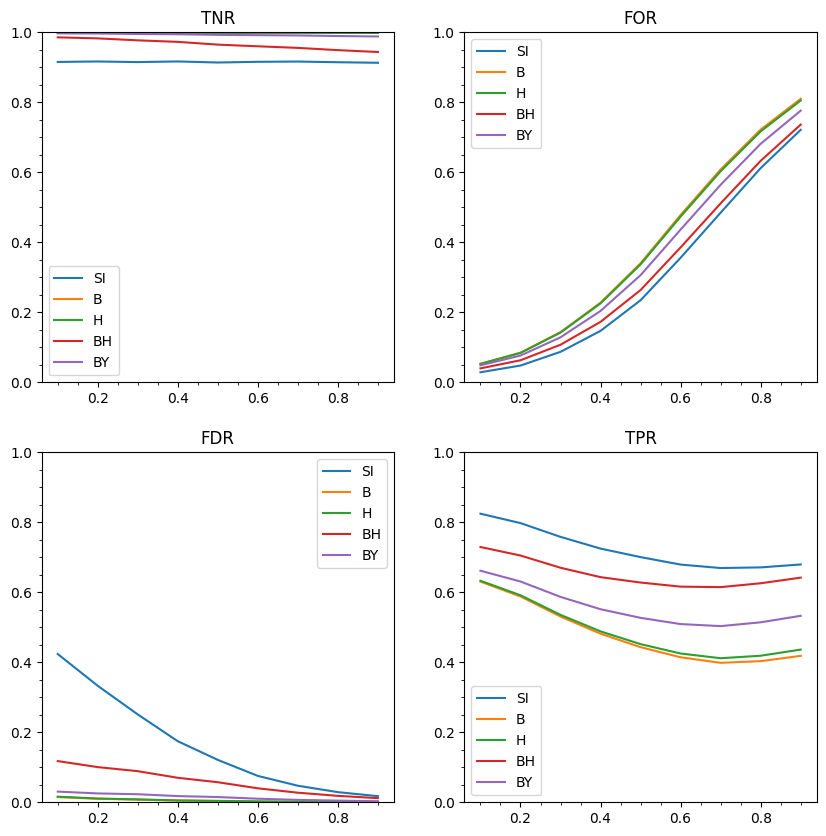

In [13]:
density_list = np.arange(0.1, 1, 0.1)

plt.subplot(2, 2, 1)
plt.plot(density_list, tnr_c[:, 0], label='SI')
plt.plot(density_list, tnr_c[:, 1], label='B')
plt.plot(density_list, tnr_c[:, 2], label='H')
plt.plot(density_list, tnr_c[:, 3], label='BH')
plt.plot(density_list, tnr_c[:, 4], label='BY')
plt.title('TNR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(density_list, fomr_c[:, 0], label='SI')
plt.plot(density_list, fomr_c[:, 1], label='B')
plt.plot(density_list, fomr_c[:, 2], label='H')
plt.plot(density_list, fomr_c[:, 3], label='BH')
plt.plot(density_list, fomr_c[:, 4], label='BY')
plt.title('FOR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(density_list, fdr_c[:, 0], label='SI')
plt.plot(density_list, fdr_c[:, 1], label='B')
plt.plot(density_list, fdr_c[:, 2], label='H')
plt.plot(density_list, fdr_c[:, 3], label='BH')
plt.plot(density_list, fdr_c[:, 4], label='BY')
plt.title('FDR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(density_list, tpr_c[:, 0], label='SI')
plt.plot(density_list, tpr_c[:, 1], label='B')
plt.plot(density_list, tpr_c[:, 2], label='H')
plt.plot(density_list, tpr_c[:, 3], label='BH')
plt.plot(density_list, tpr_c[:, 4], label='BY')
plt.title('TPR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()
plt.gcf().set_size_inches((10, 10))
plt.savefig(f'{fname}.png')
plt.show()

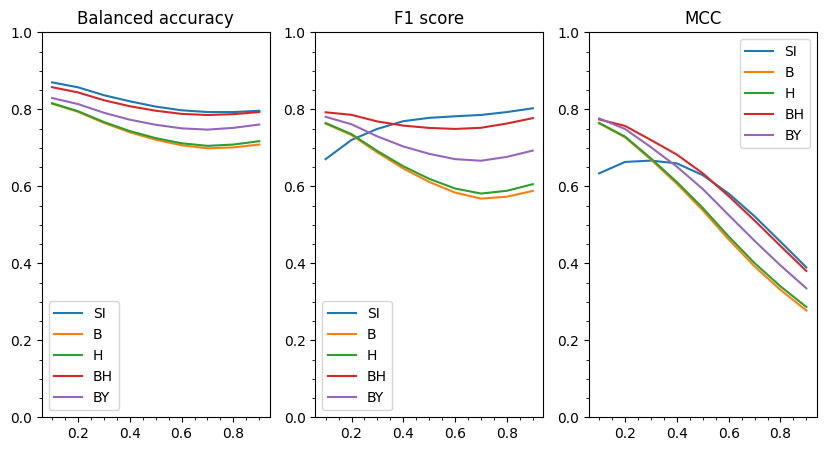

In [14]:
plt.subplot(1, 3, 1)
plt.plot(density_list, bacc_c[:, 0], label='SI')
plt.plot(density_list, bacc_c[:, 1], label='B')
plt.plot(density_list, bacc_c[:, 2], label='H')
plt.plot(density_list, bacc_c[:, 3], label='BH')
plt.plot(density_list, bacc_c[:, 4], label='BY')
plt.title('Balanced accuracy')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(density_list, f1_c[:, 0], label='SI')
plt.plot(density_list, f1_c[:, 1], label='B')
plt.plot(density_list, f1_c[:, 2], label='H')
plt.plot(density_list, f1_c[:, 3], label='BH')
plt.plot(density_list, f1_c[:, 4], label='BY')
plt.title('F1 score')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(density_list, mcc_c[:, 0], label='SI')
plt.plot(density_list, mcc_c[:, 1], label='B')
plt.plot(density_list, mcc_c[:, 2], label='H')
plt.plot(density_list, mcc_c[:, 3], label='BH')
plt.plot(density_list, mcc_c[:, 4], label='BY')
plt.title('MCC')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.gcf().set_size_inches((10, 5))
plt.savefig(f'mcc{fname}.png')
plt.show()

In [21]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [5]:
mod = CholCorrModel(5, 0.95)
data = mod.sample(1000, dist=sc.stats.multivariate_t, df=3)
slv = MHTSolver(0.05, fechner_pvalues, fechnercoef)
slv.fit(data)

In [29]:
with open(f'etc/experimentCorr100.bin', 'rb') as f:
    data1 = pickle.load(f)
    
with open(f'etc/experimentCorr100T.bin', 'rb') as f:
    data2 = pickle.load(f)

fdr_c1, fomr_c1, tnr_c1, tpr_c1, bacc_c1, f1_c1, mcc_c1 = prepare_data(data1)
fdr_c2, fomr_c2, tnr_c2, tpr_c2, bacc_c2, f1_c2, mcc_c2 = prepare_data(data2)

/tmp/ipykernel_258/2131787829.py:14: RuntimeWarning: invalid value encountered in divide
  fdr = fps / (fps + tps)
/tmp/ipykernel_258/2131787829.py:15: RuntimeWarning: invalid value encountered in divide
  fomr = fns / (fns + tns)


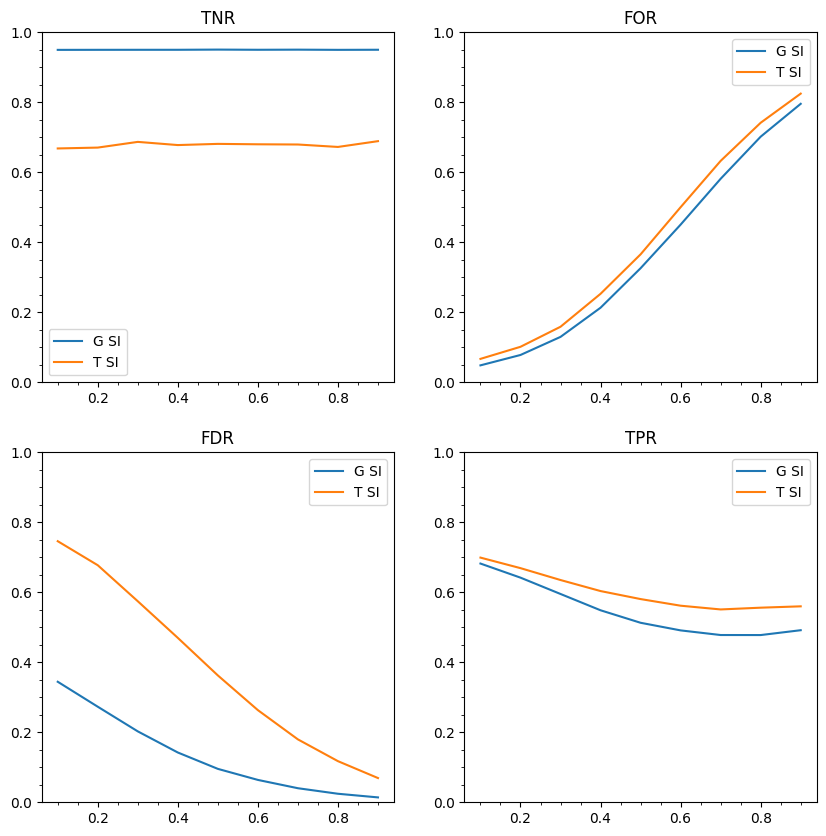

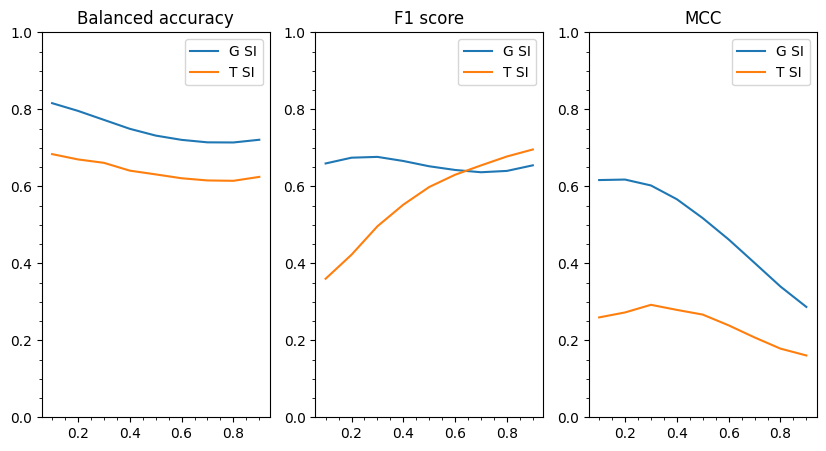

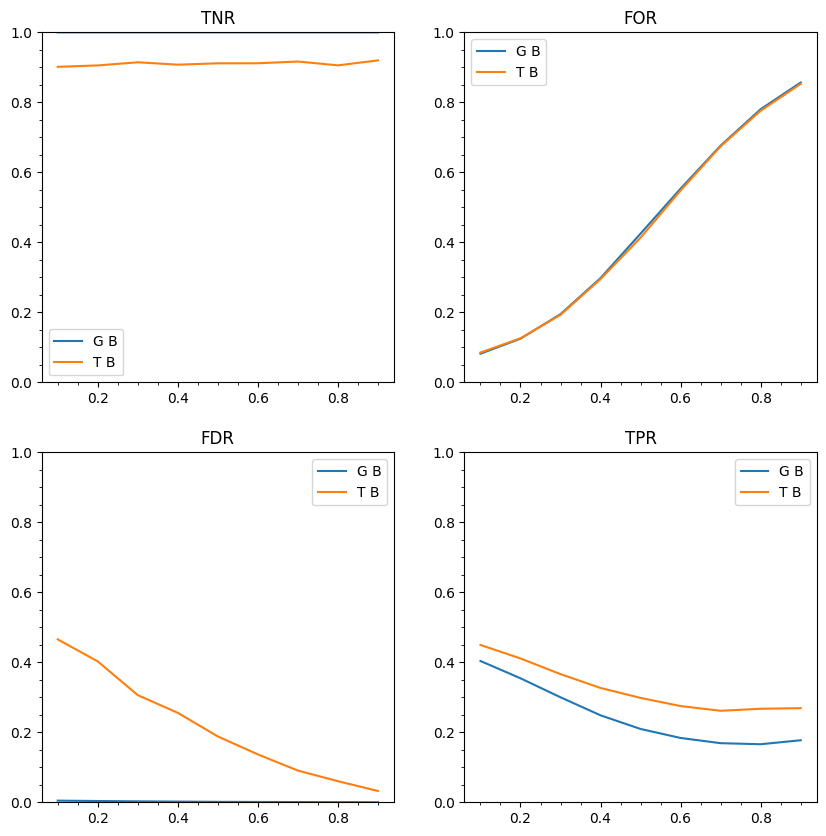

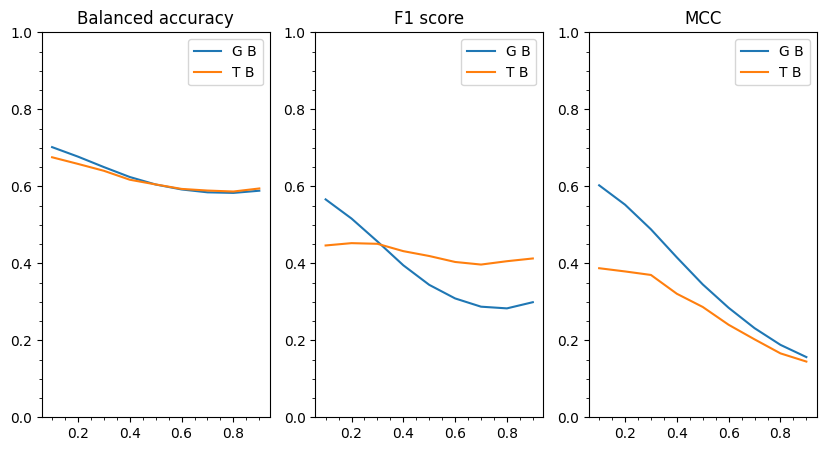

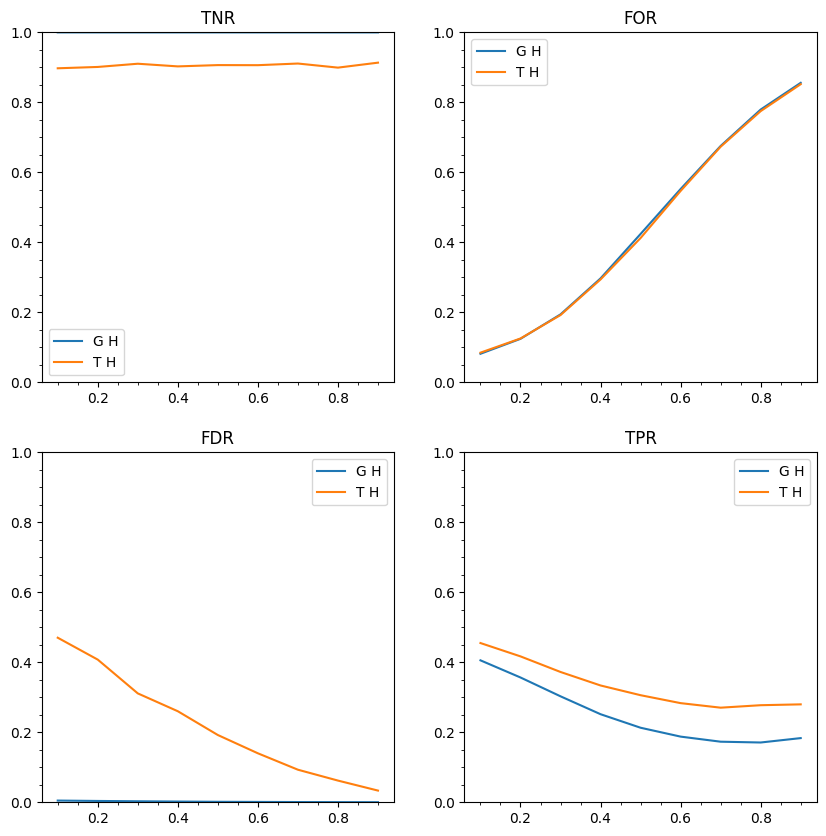

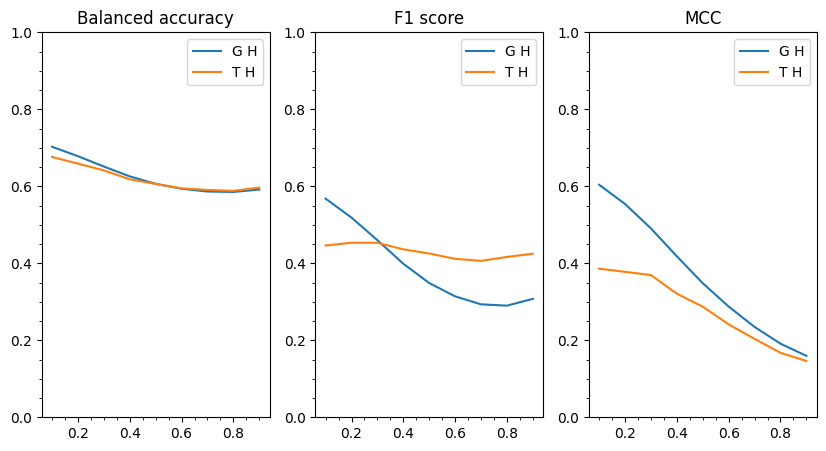

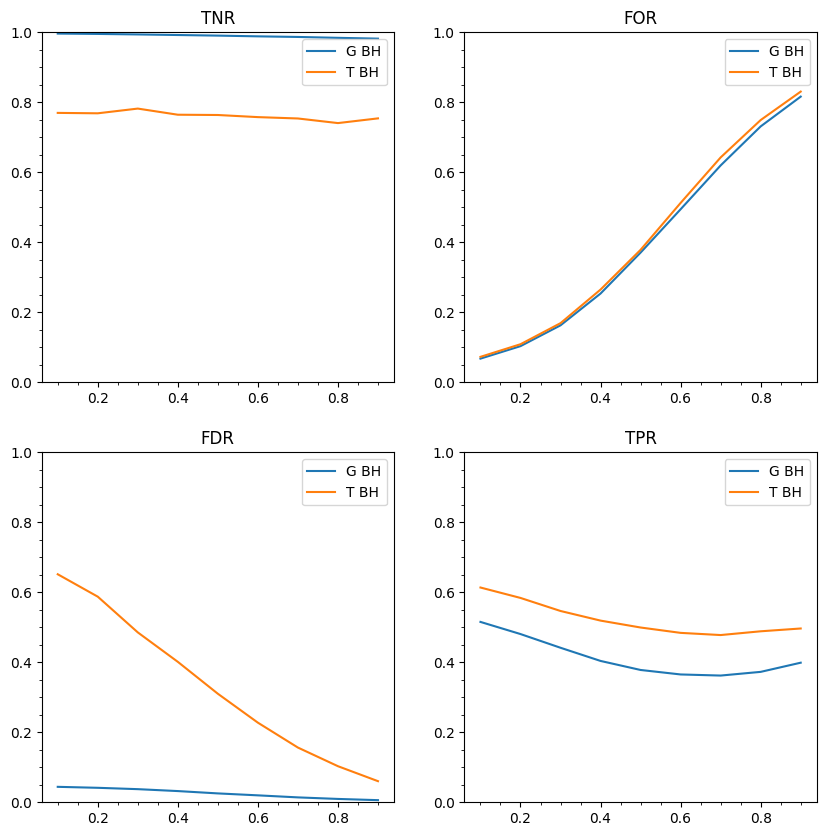

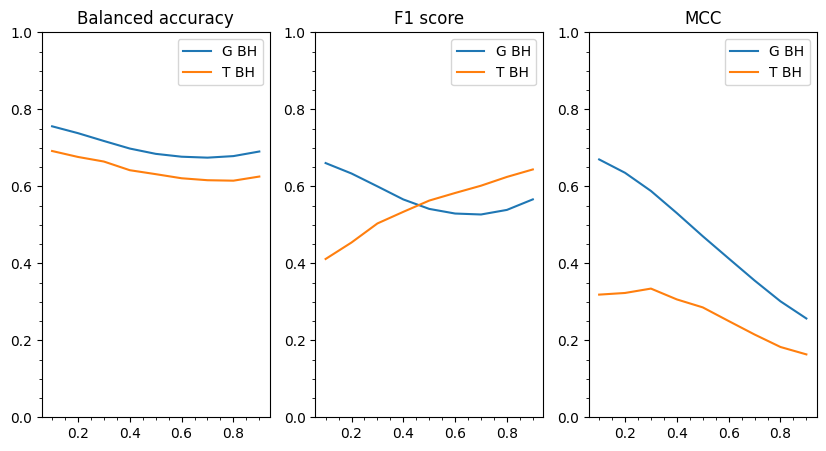

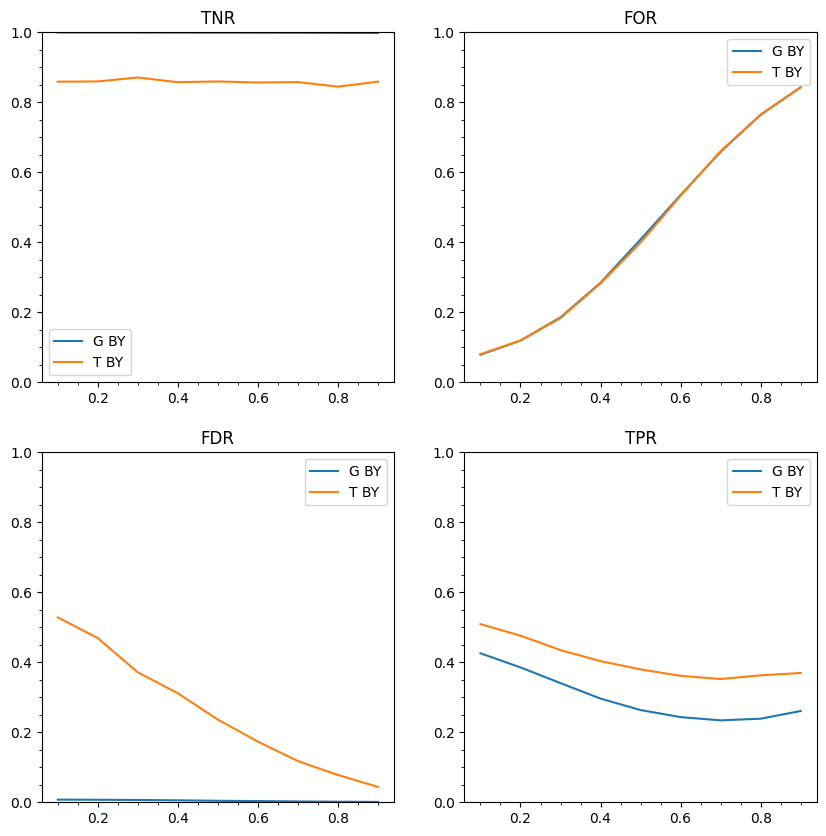

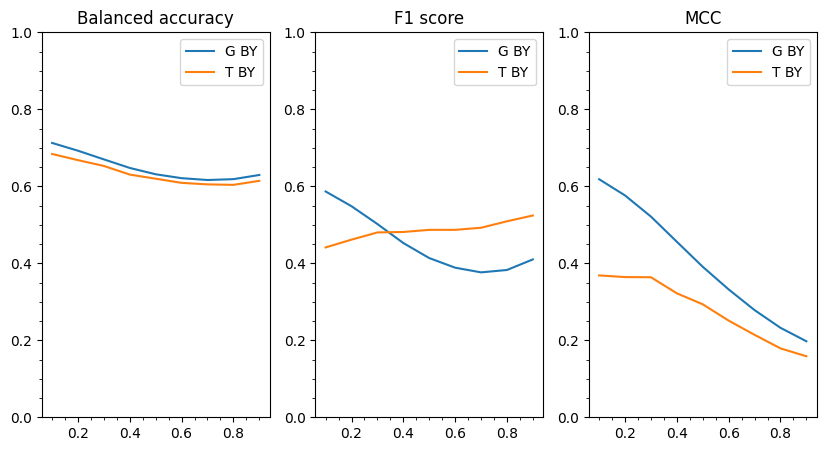

In [30]:
density_list = np.arange(0.1, 1, 0.1)

#num_algo = 1
#fname = 'BPcorr40.png'

algo_mapping = ['SI', 'B', 'H', 'BH', 'BY']
folder = 'Corr100_Comparison'

os.mkdir(folder)

for num_algo in range(5):
    fname = f'{algo_mapping[num_algo]}Corr100.png'
    plt.subplot(2, 2, 1)
    plt.plot(density_list, tnr_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, tnr_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('TNR')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(density_list, fomr_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, fomr_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('FOR')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(density_list, fdr_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, fdr_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('FDR')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(density_list, tpr_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, tpr_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('TPR')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()
    plt.gcf().set_size_inches((10, 10))
    plt.savefig(folder + '/' + fname)
    plt.show()
    
    plt.gcf().clear()
    
    plt.subplot(1, 3, 1)
    plt.plot(density_list, bacc_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, bacc_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('Balanced accuracy')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(density_list, f1_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, f1_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('F1 score')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(density_list, mcc_c1[:, num_algo], label=f'G {algo_mapping[num_algo]}')
    plt.plot(density_list, mcc_c2[:, num_algo], label=f'T {algo_mapping[num_algo]}')
    plt.title('MCC')
    plt.minorticks_on()
    plt.ylim((0, 1))
    plt.legend()

    plt.gcf().set_size_inches((10, 5))
    plt.savefig(f'{folder}/mcc{fname}')
    plt.show()

# Анализ и графики для GL

In [12]:
fname = 'experimentPcorrGL40'

with open(f'etc/{fname}.bin', 'rb') as f:
    data = pickle.load(f)
    
data.shape

(9, 1000, 200, 4, 1)

In [13]:
def prepare_data_GL(data):
    exp_combined = data.reshape((9, -1, 4, 1))
    fdr_c, fomr_c, tnr_c, tpr_c = [], [], [], []
    bacc_c, f1_c, mcc_c = [], [], []

    for i in range(9):
        tns = exp_combined[i, :, 0, :]
        fns = exp_combined[i, :, 1, :]
        fps = exp_combined[i, :, 2, :]
        tps = exp_combined[i, :, 3, :]

        tnr = tns / (fps + tns)
        tpr = tps / (fns + tps)
        fdr = fps / (fps + tps)
        fomr = fns / (fns + tns)

        fdr_f = np.nan_to_num(fdr)
        fomr_f = np.nan_to_num(fomr)
        tnr_f = np.nan_to_num(tnr, nan=1)
        tpr_f = np.nan_to_num(tpr, nan=1)

        bacc = (tpr + tnr) / 2
        f1 = hmean([1 - fdr_f, tpr_f], axis=0)

        mcc_first = tpr_f * tnr_f * (1 - fdr_f) * (1 - fomr_f)
        mcc_second = (1 - tpr_f) * (1 - tnr_f) * fomr_f * fdr_f
        mcc = np.sqrt(mcc_first) - np.sqrt(mcc_second)

        fdr_c.append(fdr_f.mean(axis=0))
        fomr_c.append(fomr_f.mean(axis=0))
        tnr_c.append(tnr_f.mean(axis=0))
        tpr_c.append(tpr_f.mean(axis=0))

        bacc_c.append(bacc.mean(axis=0))
        f1_c.append(f1.mean(axis=0))
        mcc_c.append(mcc.mean(axis=0))

    fdr_c, fomr_c, tnr_c, tpr_c = np.stack(fdr_c), np.stack(fomr_c), np.stack(tnr_c), np.stack(tpr_c)
    bacc_c, f1_c, mcc_c = np.stack(bacc_c), np.stack(f1_c), np.stack(mcc_c)
    
    return fdr_c, fomr_c, tnr_c, tpr_c, bacc_c, f1_c, mcc_c

In [14]:
fdr_c, fomr_c, tnr_c, tpr_c, bacc_c, f1_c, mcc_c = prepare_data_GL(data)

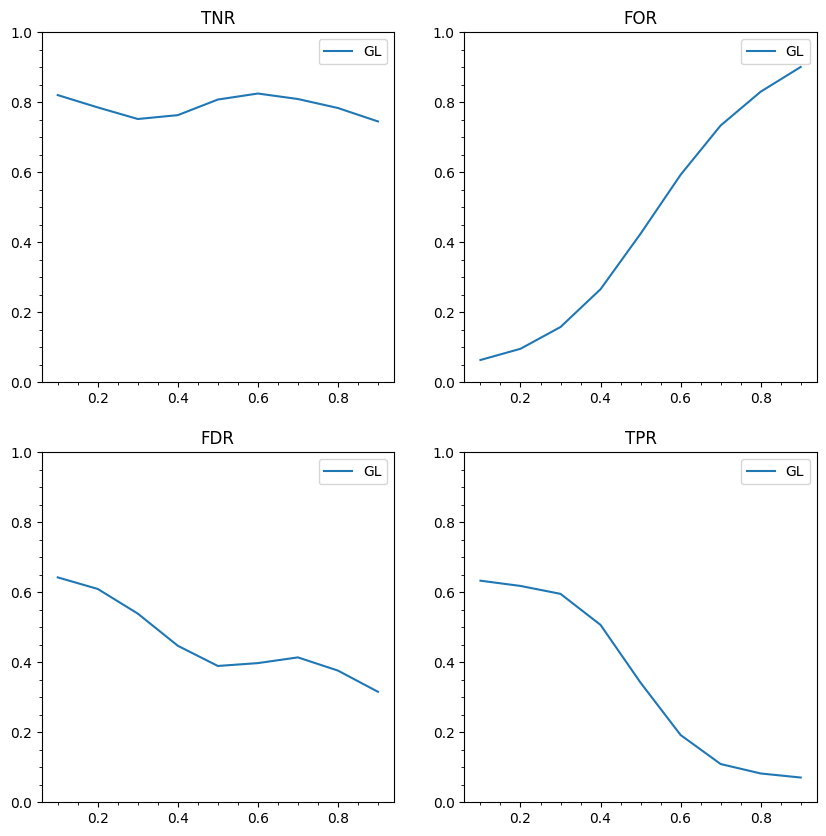

In [15]:
density_list = np.arange(0.1, 1, 0.1)

plt.subplot(2, 2, 1)
plt.plot(density_list, tnr_c[:, 0], label='GL')
plt.title('TNR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(density_list, fomr_c[:, 0], label='GL')
plt.title('FOR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(density_list, fdr_c[:, 0], label='GL')
plt.title('FDR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(density_list, tpr_c[:, 0], label='GL')
plt.title('TPR')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()
plt.gcf().set_size_inches((10, 10))
plt.savefig(f'{fname}.png')
plt.show()

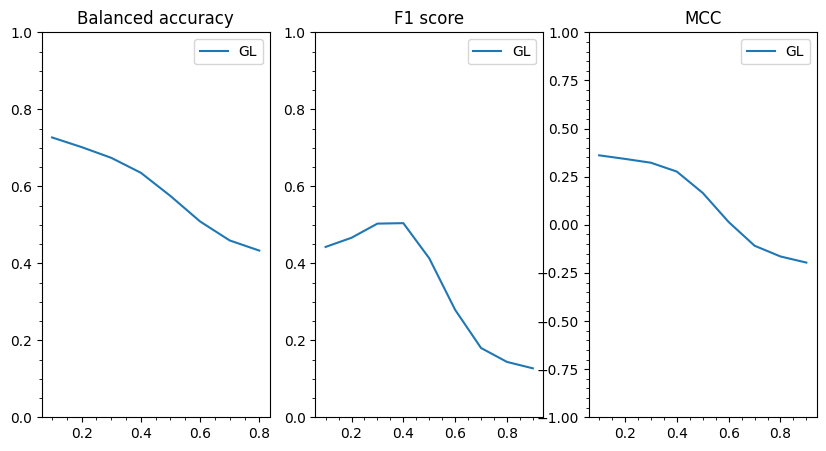

In [16]:
plt.subplot(1, 3, 1)
plt.plot(density_list, bacc_c[:, 0], label='GL')
plt.title('Balanced accuracy')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(density_list, f1_c[:, 0], label='GL')
plt.title('F1 score')
plt.minorticks_on()
plt.ylim((0, 1))
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(density_list, mcc_c[:, 0], label='GL')
plt.title('MCC')
plt.minorticks_on()
plt.ylim((-1, 1))
plt.legend()

plt.gcf().set_size_inches((10, 5))
plt.savefig(f'mcc{fname}.png')
plt.show()